In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
pi = 3.1415

coords = []

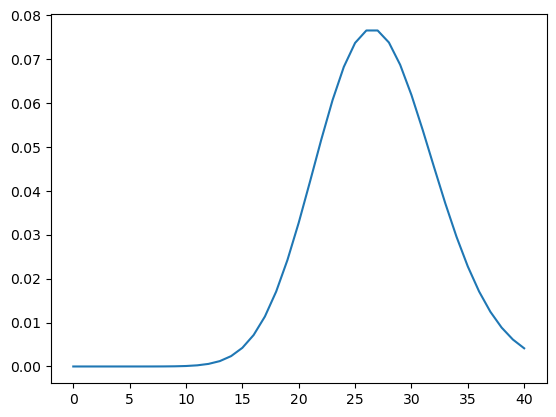

In [84]:
def poisson_distr(x, l):
    res = []
    for n in x:
        res += [l**(n) * np.exp(-l) / np.math.factorial(n)]
    return np.array(res) 

def count_within_limits(coords, hmin, hmax, rmin, rmax, phimin, phimax, thetamin, thetamax):
    count = 0
    for e in coords:
        he, re, te, pe = e
        if hmin < he < hmax and \
           rmin < re < rmax and \
           phimin < pe < phimax and \
           thetamin < te < thetamax:
            count += 1
    return count

def sample_V_hwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts_hlike = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    hs = [h/n*i + hmin for i in range(0, int(n))]
    for _ in tqdm(range(int(n-1)), "Looping h-wise"):
        counts_hlike += [count_within_limits(coords,
                                            hs[_], hs[_+1],
                                            r, R,
                                            0, 2*np.pi,
                                            0, np.pi)]
    return counts_hlike

def sample_V_rwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    rds = [(R**d - r**d)/n*i + r**d for i in range(0, int(n))]
    for _ in tqdm(range(int(n-1)), "Looping r-wise"):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        rds[_]**(1/d), rds[_+1]**(1/d),
                                        0, 2*np.pi,
                                        0, np.pi)]
    return counts

def sample_V_phiwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    phis = [(2*np.pi)/n*i for i in range(0, int(n))]
    for _ in tqdm(range(int(n-1)), "Looping phi-wise"):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        r, R,
                                        phis[_], phis[_+1],
                                        0, np.pi)]
    return counts

def sample_V_thetawise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    coss = [2/n*i -1 for i in range(0, int(n))]
    for _ in tqdm(range(int(n-1)), "Looping theta-wise"):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        r, R,
                                        0, 2*np.pi,
                                        np.arccos(coss[_+1]), np.arccos(coss[_])
                )]
    return counts

def sample_V(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    ps = [V, coords, R, r, hmin, hmax, d]
    counts_h = sample_V_hwise(*ps)
    counts_r = sample_V_rwise(*ps)
    counts_p = sample_V_phiwise(*ps)
    counts_t = sample_V_thetawise(*ps)
    print(sum(counts_h), sum(counts_r), sum(counts_r), sum(counts_p))
    return counts_h, counts_r, counts_p, counts_t

def plot_counts(counts, smallV, V, rho):
    nrows = len(counts)
    rc = 4; c = 4; r = 1*nrows
    figsize = (c * 3, r * 1.5)
    nmax = max(max([max(c) for c in counts]))
    plt.figure(figsize = figsize, tight_layout = True)
    plt.suptitle( "Testing Poisson Distribution" )
    for nr in range(nrows):
        for i in range(4):
            plt.subplot(r, c, nr*4 + i + 1)
            if not nr:
                plt.gca().set_title(f'Sampling {["h","r","phi","theta"][i]}-wise')
            data = counts[nr][i]
            x = np.array([_ for _ in range(int(max(data))+1)])
            y, binEdges = np.histogram(data, bins=x)
            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
            menStd     = np.sqrt(y)
            plt.bar(bincenters, y, width = 0.5, yerr=menStd)
            plt.plot(x, V[nr]/smallV[nr]*poisson_distr(x, smallV[nr]*rho[nr]), color="red")
            plt.xlim(0, nmax)
    plt.show()

plt.figure()
x = [i for i in range(41)]
plt.plot(x, poisson_distr(x, 27))

In [6]:
def get_causet_attrs (lambdasfile_ext):
    """

    Parameters
    ----------
    - lambdasfile_ext : str
        Name of file from which import info
    
    Returns
    ---------
    - size : int (#0)

    - dim : int (#1)

    - shapename : str (#2)

    - spacetimename : str (#3)

    - coords : list<list<float>> (#4)

    - fut_links : list<list<int>> (#5)
        Note, some are empty

    - r_S : float (#6)
    
    - molecules : list<list<int>> (#7) /not all files have that,
    so might return empty list if molecules are not saved.

    - distribution : list<list<int>> (#8) /not implemented anymore,
    should return empty list
    """
    with open(lambdasfile_ext, 'r') as fl: 
            f = fl.readlines() 

            storage_option = str(f[0].split(",")[1])
            size           = int(f[1].split(",")[1])
            dim            = int(f[2].split(",")[1])
            shapename      = str(f[3].split(",")[1])
            spacetimename  = str(f[4].split(",")[1])
            if dim > 4:
                raise AttributeError(f"Dim is {dim}: too big!!!")

            distribution = []
            mols = []
            coords = []
            r_S = 0

            #start reading file from last line
            go = -1
            while go < 0:
                row = f[go].split(",")
                key = row[0]

                if key == "":
                    go -= 1

                elif key[0:6] == "Lambda":
                    mols.append([])
                    for label in row[1:]:
                        if label != "" and label != "\n":
                            mols[-1].append(int(label))
                    go -= 1
                elif key[0:7] == "NLambda":
                    distribution.append([int(key[-1]), int(row[1])])
                    go -= 1
                
                elif key[0:3] == "HRV":
                    mols.append([])
                    for label in row[1:]:
                        if label != "" and label != "\n":
                            mols[-1].append(int(label))
                    go =- 1
                elif key[0:4] == "NHRV":
                    if key[-1] == "n":
                        distribution.append([0, int(row[1])])
                    else: #key[-1] == "e":
                        distribution.append([1, int(row[1])])
                    go -= 1

                elif "r_S" in key:
                    r_S = float(row[1])
                    go -= 1

                elif "Coordinates" in key:
                    break
                else: #the coordinates#
                    coords.insert(0, [])
                    for i in range(dim):
                        coords[0].append(float(row[i]))
                    go -= 1
        
            if storage_option == "cmatrix" or storage_option == "cmatrix\n":
                cmatrix = []
                for i in range(6, 6+size):
                    cmatrix.append(f[i].split(","))
                cmatrix = np.array(cmatrix, dtype = 'int')
                cmatrix2 = np.matmul(cmatrix, cmatrix)
                for i in range(size):
                    fut_links.append[[]]
                    for j in range(size):
                        if (cmatrix[i,j] and cmatrix2[i,j]==0):
                            fut_links[i].append[j]
            else:
                lines= [[v for v in line.split(",")] for line in open(lambdasfile_ext)]
                fut_links = [[int(v) for v in line if (v != "\n" and v != "")] 
                                for line in lines[6+3*size+3:6+4*size+3]]

    return [size,           #1
            dim,            #2
            shapename,      #3
            spacetimename,  #4

            coords,         #5
            fut_links,      #6
            r_S,            #7

            mols,           #8
            distribution]   #9

Looping theta-wise: 100%|██████████| 999/999 [00:13<00:00, 74.67it/s]


27024 27029 27029 27028


Looping theta-wise: 100%|██████████| 998/998 [00:17<00:00, 55.57it/s]


38616 38648 38648 38649


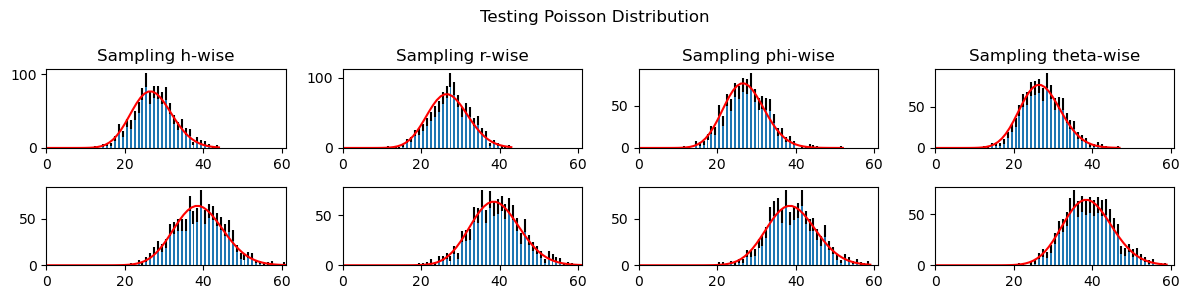

In [85]:
card = 27000
R = 3.88
h = 0.00
r = R*h
filename = f"test_poisson_cylinder_N{card}_redge{R}_h{'0.00' if not h else h}.txt"
res = get_causet_attrs(filename)
coords = res[4]
hmin = min(np.array(coords)[:,0])
hmax = max(np.array(coords)[:,0])
height = hmax-hmin
V1 = height * 4/3 * 3.1415 * (R*R*R-r*r*r)
rho1 = card/V1
smallV1 = V1/1000
while smallV1/V1*card < 10:
    smallV1 *= 1.2
counts1 = sample_V(smallV1, coords, R, r, hmin, hmax, 3)

card = 39000
R = 2.53
h = 0.58
r = R*h
filename = f"test_poisson_cylinder_N{card}_redge{R}_h{'0.00' if not h else h}.txt"
res = get_causet_attrs(filename)
coords = res[4]
hmin = min(np.array(coords)[:,0])
hmax = max(np.array(coords)[:,0])
height = hmax-hmin
V2 = height * 4/3 * 3.1415 * (R*R*R-r*r*r)
rho2 = card/V2
smallV2 = V2/1000
while smallV2/V2*card < 10:
    smallV2 *= 1.2
counts2 = sample_V(smallV2, coords, R, r, hmin, hmax, 3)

plot_counts([counts1, counts2], [smallV1, smallV2], [V1, V2], [rho1, rho2])